# A/B Testing with Real-World E-Commerce Data

Dataset is from kaggle.

Logvinov, S. (2022, September 16). A/B test data. Kaggle. https://www.kaggle.com/datasets/sergylog/ab-test-data

This project applies statistical techniques—including t-tests, chi-square tests, and exploratory data analysis—to evaluate the impact of an A/B experiment on user conversion and revenue behavior in an e-commerce setting.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from scipy.stats import norm, zscore, chi2_contingency, f_oneway

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sergylog/ab-test-data")

# print("Path to dataset files:", path)

filename = 'AB_Test_Results.csv'

csv_path = os.path.join(path, filename)

df = pd.read_csv(csv_path)

df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [ ]:
df.isnull().sum()

,0
USER_ID,0
VARIANT_NAME,0
REVENUE,0


In [ ]:
df = df.drop_duplicates(subset=['USER_ID', 'VARIANT_NAME'])

### Normality test to determine distribution pattern

Look out for:
  1. Data skew
  2. Non-normal distribution

In [ ]:
# Begin with Shapiro-Wilk ttest

t_test, p_value = stats.shapiro(df['REVENUE'])
print('p-value:', p_value)

p-value: 5.142421700727746e-108


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7865.
  res = hypotest_fun_out(*samples, **kwds)


The Shapiro-Wilk ttest gives a warning that the p-value may not be entirely accurate due to large dataset size. So, it is best to try another ttest: the Kolmogorov–Smirnov ttest

In [ ]:
# First, standardize the REVENUE data to ensure normality. Then, perform ttest.

std_revenue = zscore(df['REVENUE'])

t_stat, p_value = stats.kstest(std_revenue, 'norm')
print(f"p-value: {p_value}")

p-value: 0.0


The p-value is 0.0 even after standardization, which indicates that the data is not normally distributed.
As a result, ttests are not usable as they require data to have a gaussian distribution.
The next step is to use non-parametric tests, such as the Mann-Whitney U test.

In [ ]:
# Mann-Whitney U test

control = df[df['VARIANT_NAME'] == 'control']['REVENUE']
variant = df[df['VARIANT_NAME'] == 'variant']['REVENUE']

u_value, p_value = stats.mannwhitneyu(control, variant)
print('p-value:', p_value)

p-value: 0.7830921177007305


The results of the p-value indicate that there are no statically significant differences in the two group (control and variant) revenues. The null hypothesis cannot be rejected.

Next, test for Conversion Rates using Chi Square.

In [ ]:
df['CONVERTED'] = df['REVENUE'] > 0 # Define the conversion column

contingency_tab = pd.crosstab(df['VARIANT_NAME'], df['CONVERTED'])
print(contingency_tab)

CONVERTED     False  True 
VARIANT_NAME              
control        3878     53
variant        3878     56


In [ ]:
chi2, p_value, dof, expected = chi2_contingency(contingency_tab)

print(f"Chi Square: {chi2:.4f}")
print(f"p-value: {p_value:.4f}")

Chi Square: 0.0357
p-value: 0.8502


As observed from the p-value, there is no statistically significant difference in conversion rates between the control and variant groups. The new variant did not improve or worsen conversions in a meaningful way.

Optional, but here are the actual conversion rates of each group.

In [ ]:
# Actual Conversion Rates

conversion_rates = df.groupby('VARIANT_NAME')['CONVERTED'].mean() * 100
print(conversion_rates)

VARIANT_NAME
control    1.348257
variant    1.423488
Name: CONVERTED, dtype: float64


For educational purposes - introduce a new variable to do an ANOVA test.

In [ ]:
# Introducing 'USER_TYPE'

np.random.seed(0)

df['USER_TYPE'] = np.random.choice(['Premium', 'Regular', 'New'], size=len(df))

# Run ANOVA test

grouped = df.groupby('USER_TYPE')['REVENUE']

f_stat, p_value = f_oneway(*[i[1] for i in grouped])

print(f"F-Stat: {f_stat}, p-value: {p_value}")

F-Stat: 0.9683244898839339, p-value: 0.3797640099500993


Based off the results of the ANOVA test, there is no statistically significant difference in average revenue between Premium, Regular, and New user types.

## Visualize the results

Revenue by Variant

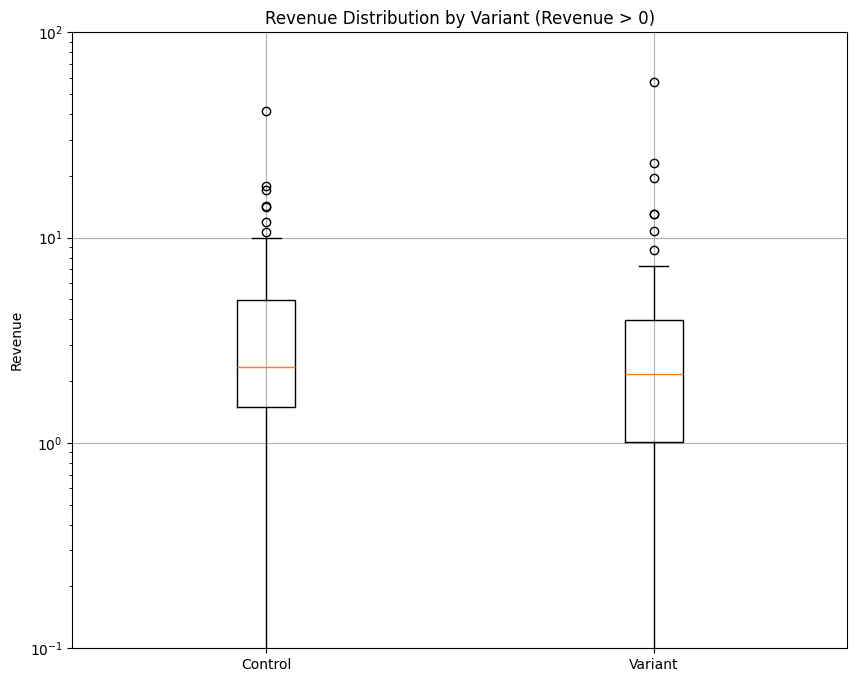

In [ ]:
# Boxplot - Revenue by Variant

fig = plt.figure(figsize=(10,8))

data_bp = [df[(df['VARIANT_NAME'] == i) & (df['REVENUE'] > 0)]['REVENUE'] for i in ['control', 'variant']] # Removes revenue of 0

plt.boxplot(data_bp, tick_labels=['Control', 'Variant'])
plt.title('Revenue Distribution by Variant (Revenue > 0)')
plt.ylabel('Revenue')
plt.yscale('log')
plt.ylim(0.1,100)
plt.grid(True)
plt.show()

Conversion Rate by Variant

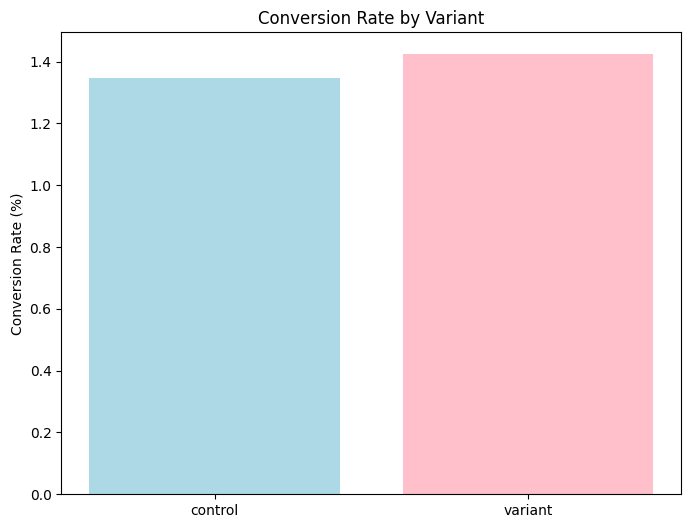

In [ ]:
# Conversion Rate by Variant

data_bar = df.groupby('VARIANT_NAME')['CONVERTED'].mean() * 100

plt.figure(figsize=(8,6))
plt.bar(data_bar.index, data_bar.values, color=['lightblue', 'pink'])
plt.title('Conversion Rate by Variant')
plt.ylabel('Conversion Rate (%)')
plt.show()

Revenue by User Type

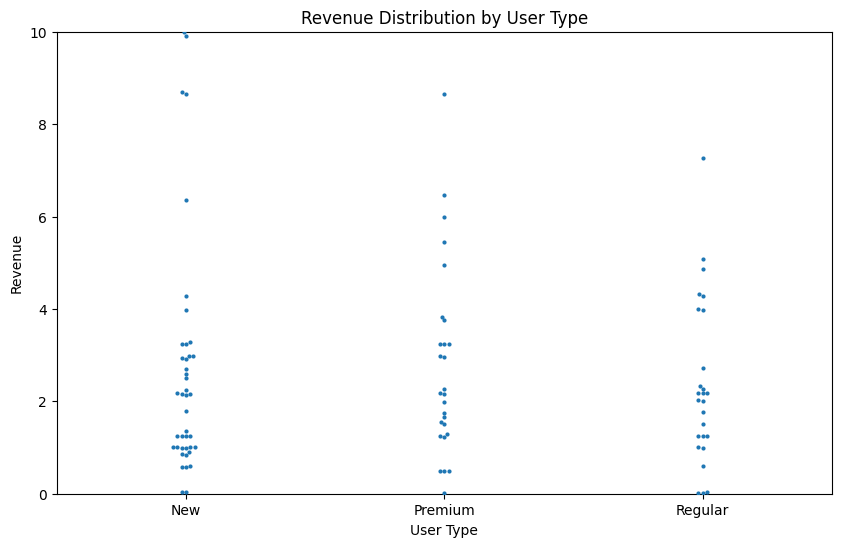

In [ ]:
# Revenue by User Type

plt.figure(figsize=(10, 6))
sns.swarmplot(x='USER_TYPE', y='REVENUE', data=df[df['REVENUE'] > 0], size=3)
plt.title('Revenue Distribution by User Type')
plt.ylabel('Revenue')
plt.xlabel('User Type')
plt.ylim(0, 10)
plt.show()

## Conclusion

This project applied A/B testing and statistical analysis techniques to evaluate the impact of a website variant on user revenue and conversion behavior using simulated e-commerce data. Through tests such as the Mann-Whitney U and Chi-Square, we found no statistically significant differences in revenue or conversion rate between the control and variant groups, indicating that the new variant did not outperform the original design. Additionally, an ANOVA test on a synthetic USER_TYPE variable revealed no significant revenue differences across user categories. Visualizations including boxplots, bar charts, swarm plots, and violin plots helped illustrate the distribution patterns and supported our statistical findings. Overall, the analysis suggests that the tested changes did not yield measurable improvements, but the process effectively demonstrated a complete A/B testing workflow, from data cleaning to insight generation.